In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

In [2]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist.data.astype(np.float32)   # (70000, 784)
y = mnist.target.astype(np.int64)   # 0..9

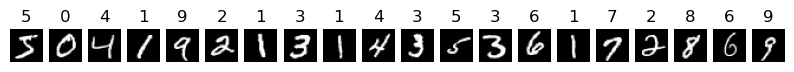

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.imshow(mnist.data[i].reshape(28, 28), cmap="gray")
    plt.title(mnist.target[i])
    plt.axis("off")
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=42, stratify=y
)

In [4]:
clf = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(300,),
        activation="relu",
        solver="adam",
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=50,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        random_state=42,
        verbose=False
    ))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [5]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall    (macro): {recall:.4f}")
print(f"F1        (macro): {f1:.4f}\n")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy : 0.9777
Precision (macro): 0.9778
Recall    (macro): 0.9775
F1        (macro): 0.9776

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       986
           1       0.98      0.99      0.99      1125
           2       0.98      0.97      0.98       999
           3       0.97      0.98      0.98      1020
           4       0.98      0.97      0.98       975
           5       0.98      0.97      0.97       902
           6       0.98      0.99      0.99       982
           7       0.97      0.97      0.97      1042
           8       0.98      0.97      0.98       975
           9       0.96      0.97      0.96       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



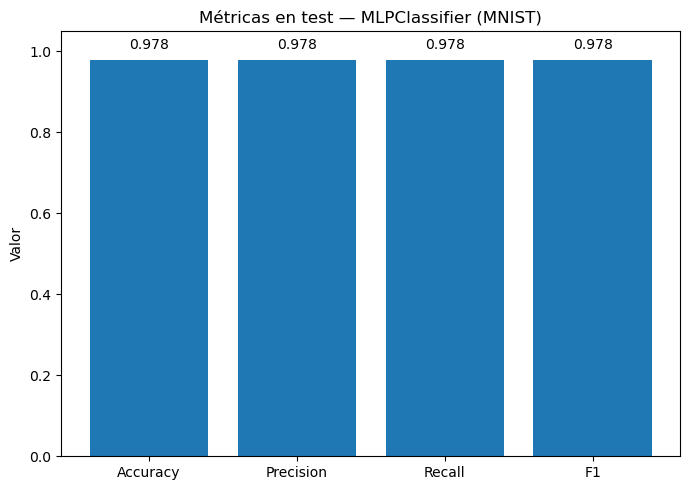

In [6]:
metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metric_vals  = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
bars = plt.bar(metric_names, metric_vals)
plt.ylim(0, 1.05)
plt.title("Métricas en test — MLPClassifier (MNIST)")
plt.ylabel("Valor")
for rect, val in zip(bars, metric_vals):
    h = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, h + 0.02, f"{val:.3f}",
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

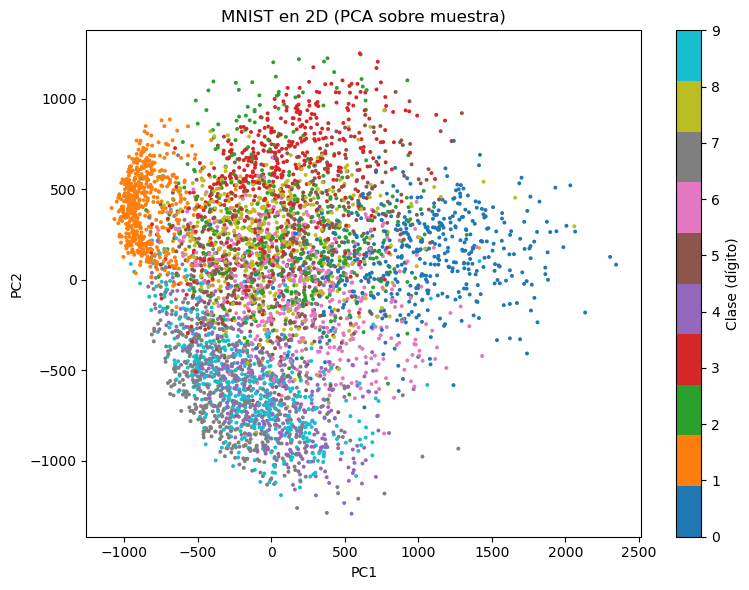

In [7]:
pca_viz = PCA(n_components=2, random_state=42)
rng = np.random.RandomState(42)
sample_size = min(5000, len(X))
idx_sample = rng.choice(len(X), size=sample_size, replace=False)
X_pca = pca_viz.fit_transform(X[idx_sample])

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y[idx_sample], cmap="tab10", s=8, edgecolor="none")
plt.title("MNIST en 2D (PCA sobre muestra)")
plt.xlabel("PC1"); plt.ylabel("PC2")
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label("Clase (dígito)")
plt.tight_layout()
plt.show()

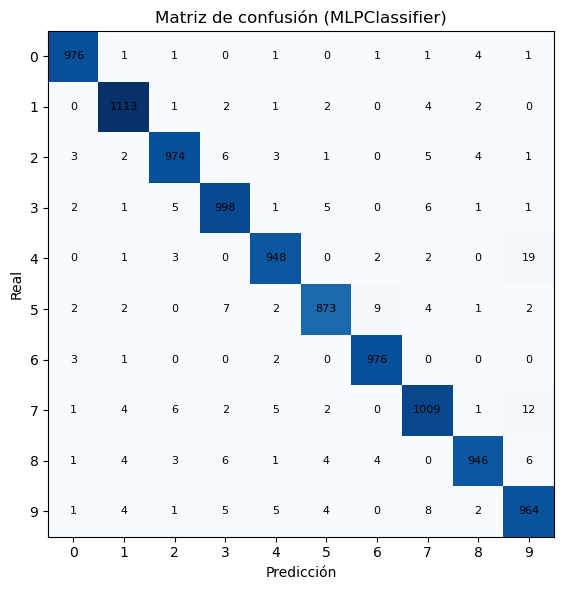

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Matriz de confusión (MLPClassifier)")
plt.xticks(ticks=range(10), labels=range(10))
plt.yticks(ticks=range(10), labels=range(10))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.tight_layout()
plt.show()

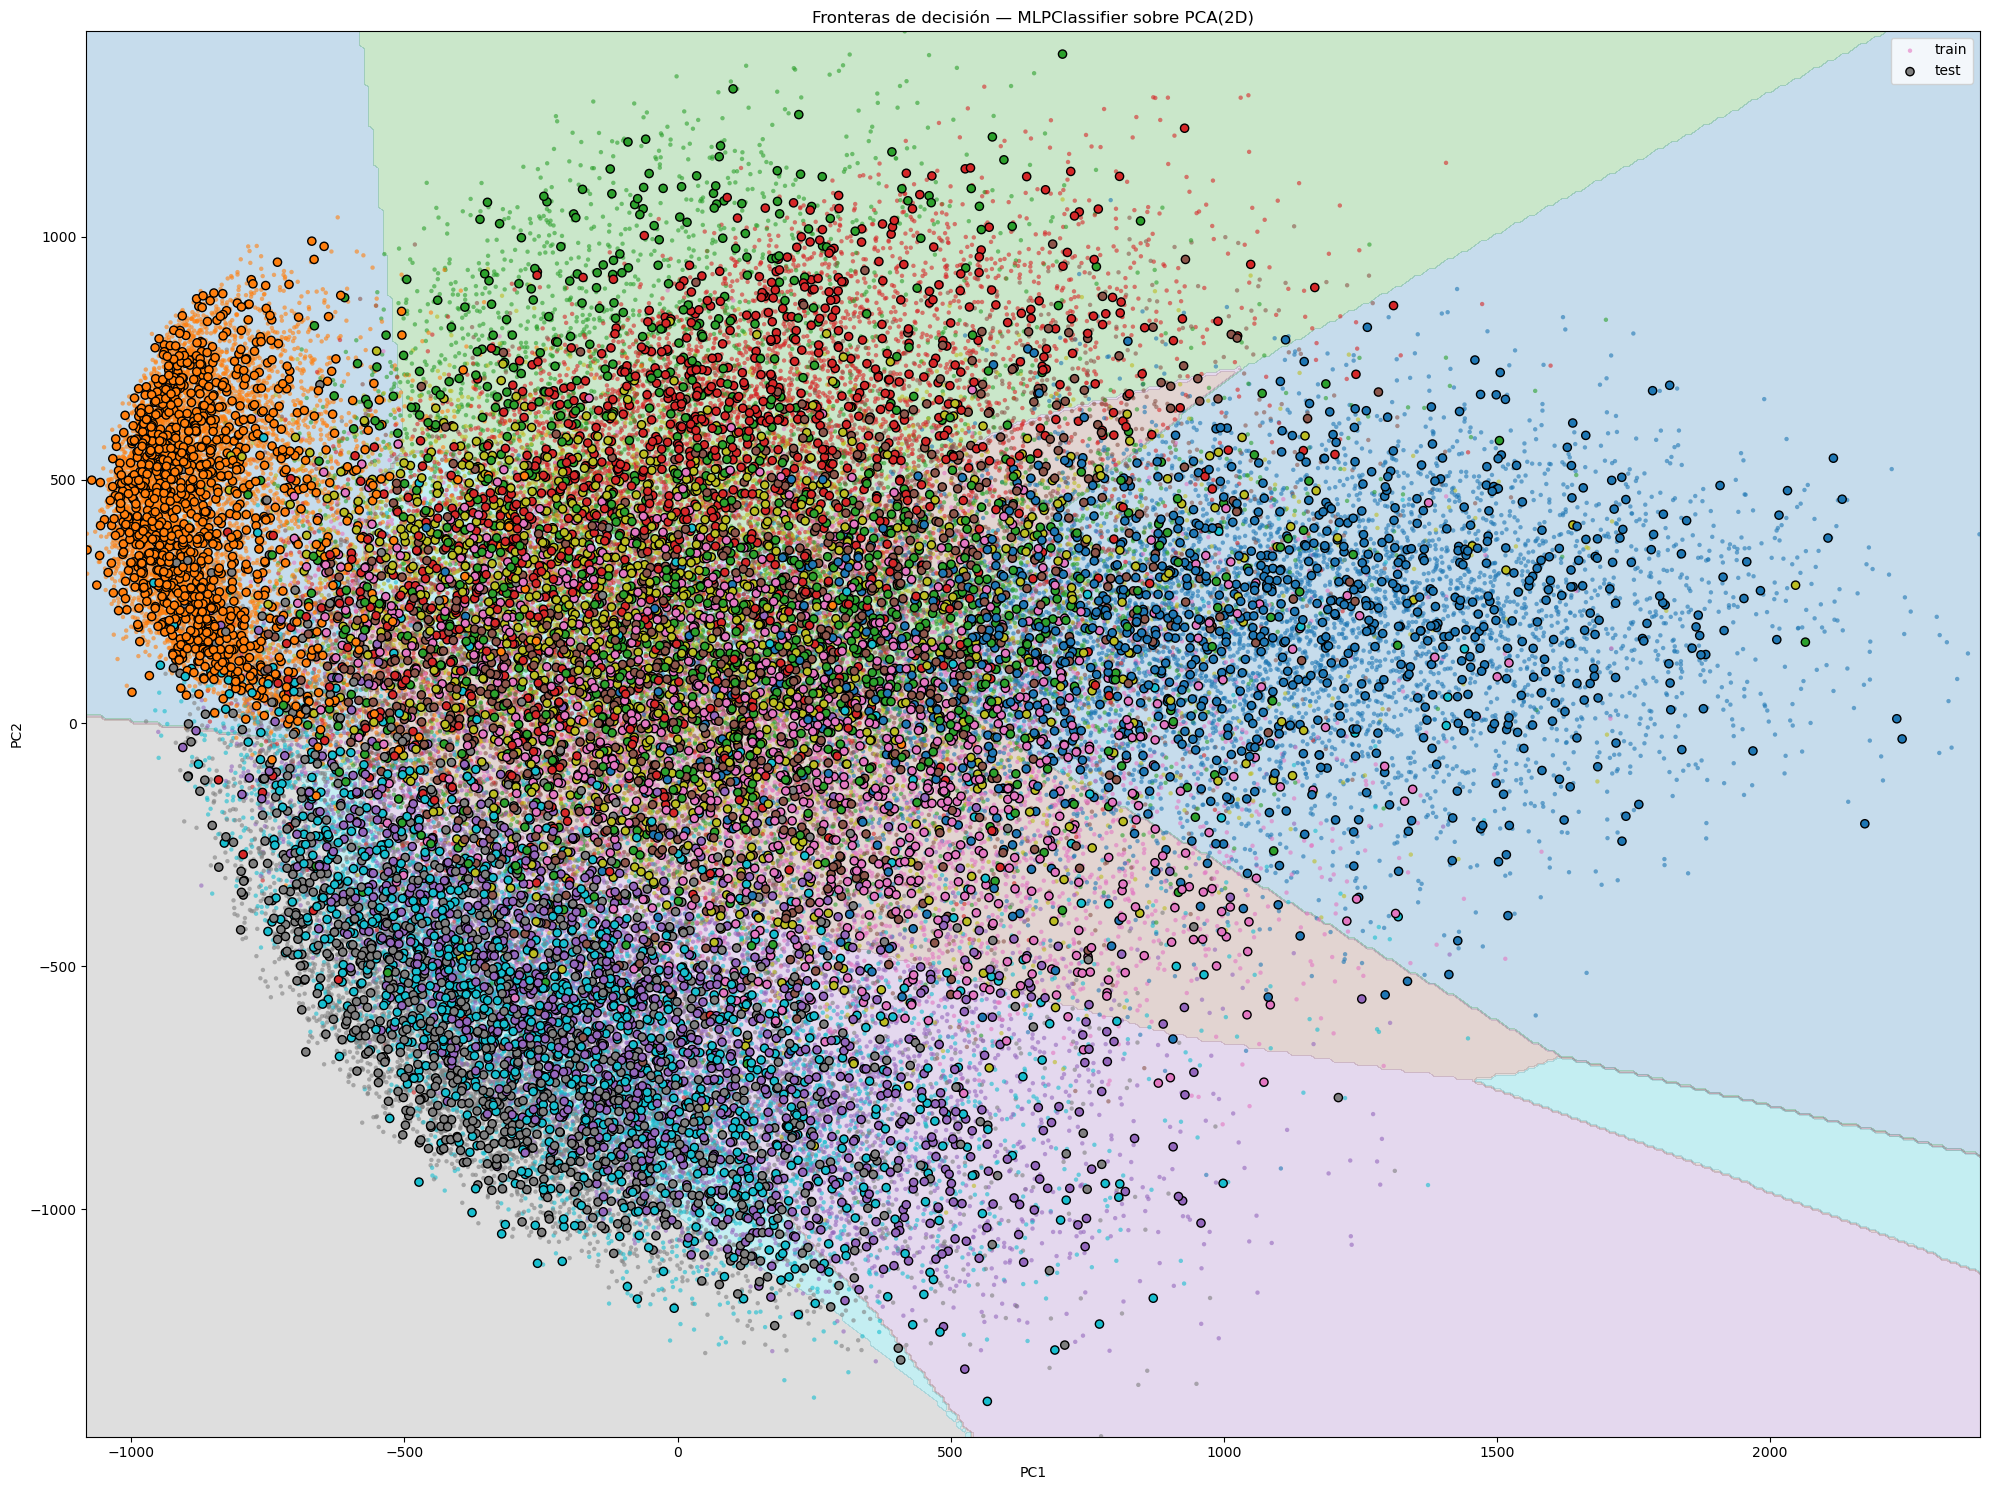

In [10]:
pca2 = PCA(n_components=2, random_state=42)
X_train_pca = pca2.fit_transform(X_train)
X_test_pca  = pca2.transform(X_test)

clf2d = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(50,),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        max_iter=200,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42
    ))
])
clf2d.fit(X_train_pca, y_train)

# malla en el plano PCA
x_min, x_max = X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1
y_min, y_max = X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
Z = clf2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(20,15))
plt.contourf(xx, yy, Z, alpha=0.25, cmap="tab10")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap="tab10",
            s=10, edgecolor="none", alpha=0.6, label="train")
plt.scatter(X_test_pca[:,0],  X_test_pca[:,1],  c=y_test,  cmap="tab10",
            s=35, edgecolor="k",   label="test")
plt.title("Fronteras de decisión — MLPClassifier sobre PCA(2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()
